## Bayesian Media Mix Modeling Demo
# Full workflow from data simulation to model evaluation

In [1]:
# %%
# !pip install -r ../requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import sys
sys.path.append("..")  # Adds parent directory to Python path
from src import data_simulation, propensity_score, bayesian_model, ab_testing

az.style.use("arviz-darkgrid")
np.random.seed(42)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# %%
# Generate synthetic data
df = data_simulation.generate_data(n=180, adstock=True)
print("Synthetic Data:")
print(df.head())

Synthetic Data:
        date    tv_spend  digital_spend  competitor_promo  holiday       sales
0 2023-01-01  114.901425     130.595642                 1        0  378.551709
1 2023-01-02  182.028139     104.643824                 0        0  522.121487
2 2023-01-03  255.951761      83.881295                 0        1  657.019003
3 2023-01-04  337.654716     160.458203                 0        1  765.101048
4 2023-01-05  346.216436     149.954228                 0        1  716.964724


C:\Users\wyy\AppData\Local\Temp\ipykernel_19076\2167348738.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


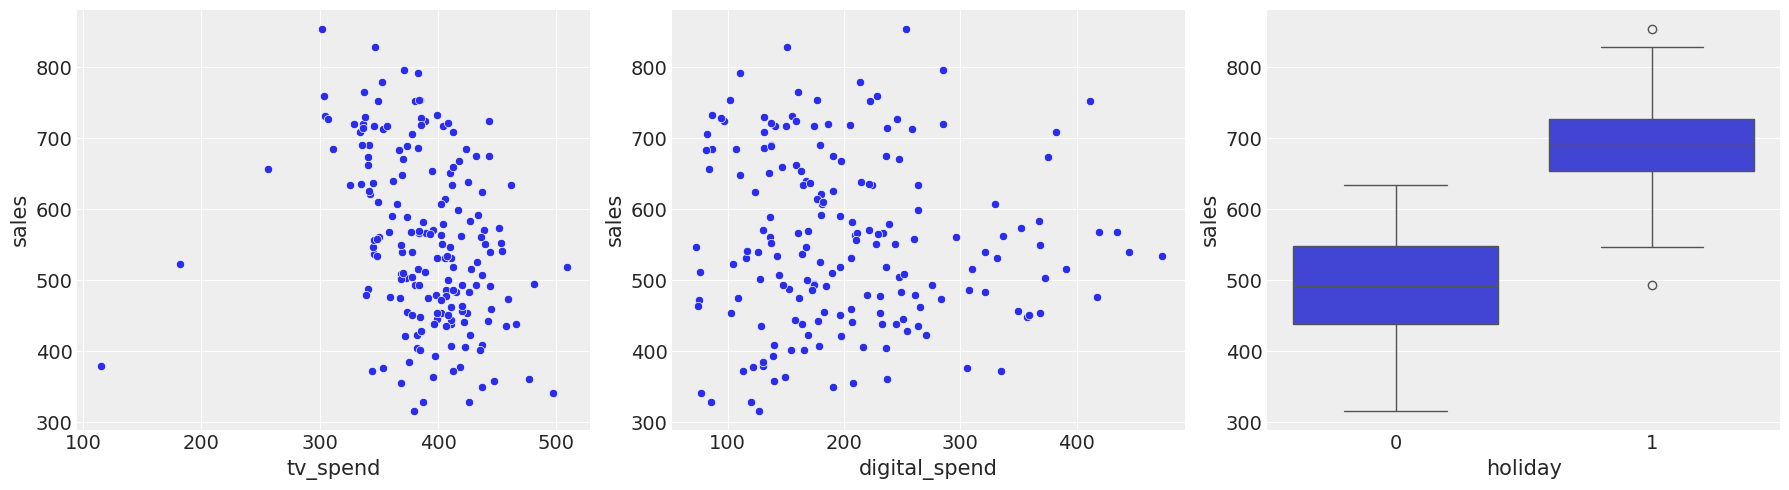

In [3]:
# %%
# Visualize relationships
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x='tv_spend', y='sales', data=df, ax=ax[0])
sns.scatterplot(x='digital_spend', y='sales', data=df, ax=ax[1])
sns.boxplot(x='holiday', y='sales', data=df, ax=ax[2])
plt.tight_layout()
plt.savefig('media_sales_relationships.png', dpi=300)

In [4]:
# %%
# Create treatment variable: High TV Campaign
df['high_tv'] = (df['tv_spend'] > df['tv_spend'].quantile(0.75)).astype(int)

In [5]:
# %%
# Calculate propensity scores
confounders = ['digital_spend', 'competitor_promo', 'holiday']
ps_scores = propensity_score.calculate_propensity_scores(
    df, treatment_var='high_tv', confounders=confounders
)
df['propensity_score'] = ps_scores

Initializing NUTS using jitter+adapt_diag...
c:\Users\wyy\Documents\GitHub\Media Mix Modeling\Media-Mix-Modeling\.venv\Lib\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 576 seconds.
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


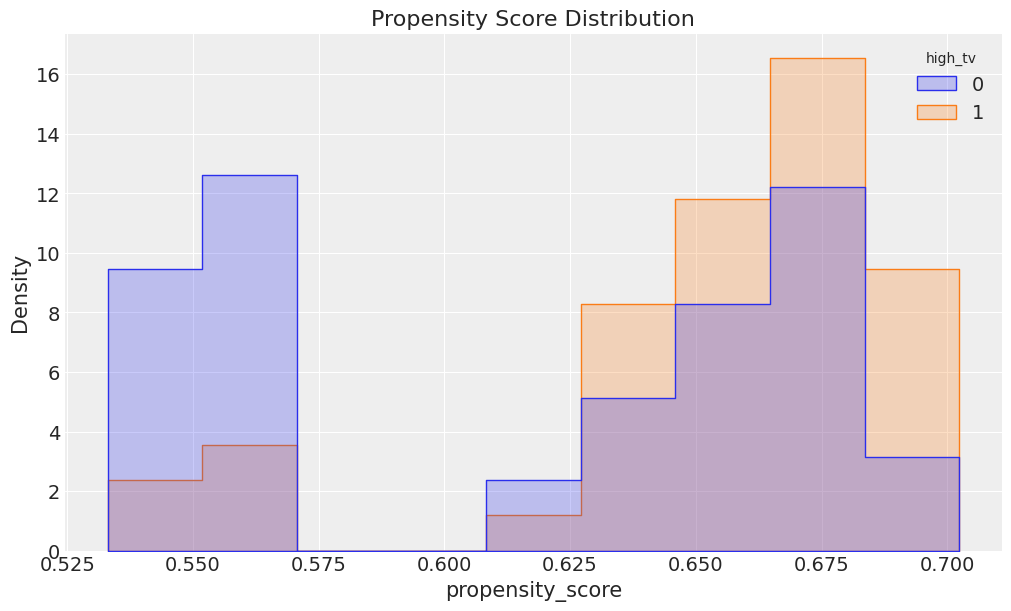

In [6]:
# %%
# Plot propensity score distribution
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df, 
    x='propensity_score', 
    hue='high_tv', 
    element='step', 
    stat='density',
    common_norm=False
)
plt.title('Propensity Score Distribution')
plt.savefig('propensity_scores.png', dpi=300)


In [7]:
# %%
# Prepare data for modeling
X = df[['tv_spend', 'digital_spend', 'competitor_promo', 'holiday']]
y = df['sales']

# Inverse probability weights
weights = np.where(df['high_tv'], 1/df['propensity_score'], 1/(1-df['propensity_score']))

In [8]:
# %%
# Run Bayesian MMM
model, trace = bayesian_model.run_bayesian_mmm(
    X.values, 
    y.values,
    ps_scores=weights
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, l1_strength, alpha, sigma]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 924 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


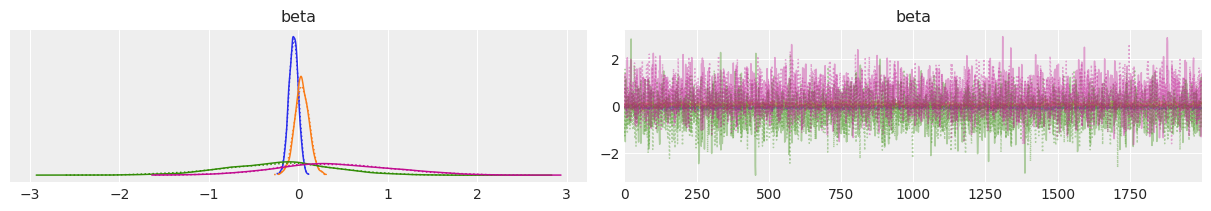

In [9]:
# %%
# Model diagnostics
az.summary(trace, var_names=['alpha', 'beta', 'sigma'])
az.plot_trace(trace, var_names=['beta'])
plt.savefig('trace_plot.png', dpi=300)

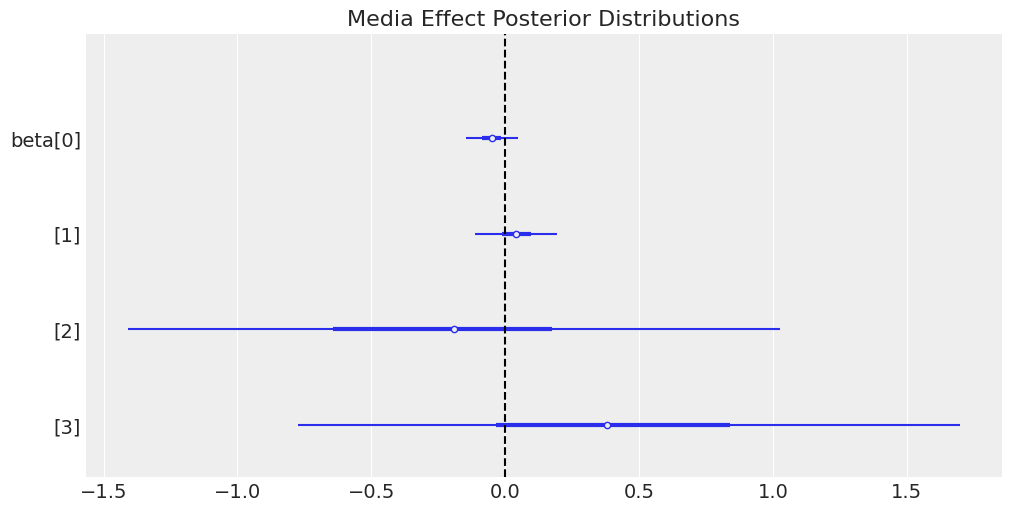

In [10]:
# %%
# Plot posterior distributions
az.plot_forest(trace, var_names=['beta'], combined=True, figsize=(10, 5))
plt.axvline(0, color='k', linestyle='--')
plt.title('Media Effect Posterior Distributions')
plt.savefig('posterior_distributions.png', dpi=300)

In [14]:
# %%
# A/B Testing Simulation
control = np.random.normal(1000, 50, 100)
treatment = np.random.normal(1120, 50, 100)

ab_model, ab_trace = ab_testing.bayesian_ab_test(control, treatment)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_control, mu_variant, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 224 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


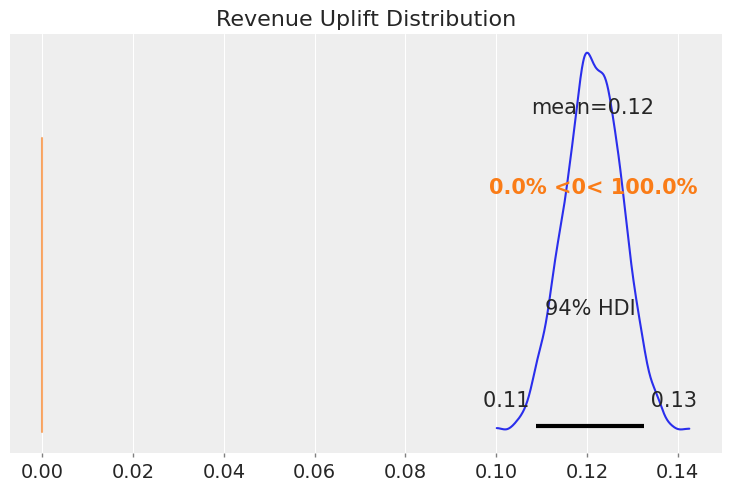

In [15]:
# %%
# A/B Test results
az.plot_posterior(ab_trace, var_names=['uplift'], ref_val=0)
plt.title('Revenue Uplift Distribution')
plt.savefig('ab_test_results.png', dpi=300)